<a href="https://colab.research.google.com/github/astrfo/SRS-CH/blob/main/SRS_CH_Decimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRS-CH 実装 (Decimal 型)

[満足化方策における非満足均衡を用いた確率的方策の検証] \\
https://www.jstage.jst.go.jp/article/pjsai/JSAI2021/0/JSAI2021_1G2GS2a04/_article/-char/ja/


[論文要約] \\
https://colab.research.google.com/drive/1PGbrYECAT7JiiOF_Zu0Sg8CzqjPTJE87#scrollTo=iaPmWlGNgFbd




In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import time
from tqdm import tqdm
from decimal import Decimal, getcontext, FloatOperation, InvalidOperation, DivisionByZero

getcontext().traps[FloatOperation] = True
getcontext().traps[InvalidOperation] = False 
getcontext().traps[DivisionByZero] = False

%matplotlib inline

In [ ]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([Decimal(f'{np.random.rand()}') for _ in range(self._K)])

    def play(self, arm):
        if self.prob[arm] > Decimal(f'{np.random.rand()}'):
            return 1
        else:
            return 0

In [ ]:
class TS(object):
    """
    Thompson Sampling
    """

    def __init__(self, K):
        self._K = K
        self._S = None      # Success
        self._F = None      # Failure

    def initialize(self):
        self._S = np.array([Decimal('1.0')] * self._K)
        self._F = np.array([Decimal('1.0')] * self._K)

    def select_arm(self):
        theta = np.array([Decimal(f'{np.random.beta(self._S[i], self._F[i])}') for i in range(self._K)])
        arm = np.random.choice(np.where(theta == theta.max())[0])
        return arm

    def update(self, arm, reward):
        if reward == 1:
            self._S[arm] += 1
        else:
            self._F[arm] += 1

In [ ]:
class RS(object):
    """
    RS (aleph=p1)
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._RS = None

    def initialize(self):
        self._V = np.array([Decimal('0.5')] * self._K)
        self._n = np.array([Decimal('1e-6')] * self._K)
        self._N = np.sum(self._n)
        self._RS = (self._n / (self._N)) * (self._V - self.aleph)

    def select_arm(self):
        arm = np.random.choice(np.where(self._RS == self._RS.max())[0])
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N)) * (self._V - self.aleph)

In [ ]:
class RS_OPT(object):
    """
    RS-OPT
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._RS = None

    def initialize(self):
        self._V = np.array([Decimal('0.5')] * self._K)
        self._n = np.array([Decimal('1e-6')] * self._K)
        self._N = np.sum(self._n)
        self._RS = (self._n / (self._N)) * (self._V - self.aleph)

    def select_arm(self):
        arm = np.random.choice(np.where(self._RS == self._RS.max())[0])
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N)) * (self._V - self.aleph)

In [ ]:
class RS_Dyn(object):
    """
    RS-Dyn
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._beta = Decimal('0.001')      # 進捗報告 2021/08/16までの結果より
        self._V = None
        self._n = None
        self._N = None
        self._aleph = None
        self._RS = None

    def initialize(self):
        self._aleph = Decimal('1.0')       # th2021 M1-01非定常環境に対応する確率的認知的満足化 - 総合考察より
        self._V = np.array([Decimal('0.5')] * self._K)
        self._n = np.array([Decimal('1e-6')] * self._K)
        self._N = np.sum(self._n)
        self._RS = (self._n / (self._N)) * (self._V - self._aleph)

    def select_arm(self):
        arm = np.random.choice(np.where(self._RS == self._RS.max())[0])
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N)) * (self._V - self._aleph)
        self._aleph += self._beta * (self._V[arm] - self._aleph)

In [ ]:
class RS_CH(object):
    """
    RS-CH
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self._aleph = None
        self._RS = None

    def initialize(self):
        self._V = np.array([Decimal('0.5')] * self._K)
        self._n = np.array([Decimal('1e-6')] * self._K)
        self._N = np.sum(self._n)
        self._aleph = np.zeros(self._K)
        self._RS = (self._n / (self._N)) * (self._V - self._aleph)

    def select_arm(self):
        G = random.choice(np.where(self._V == self._V.max())[0])
        RSG = (self._n[G] / (self._N)) * (self._V[G] - self._aleph)
        mu = np.exp(-self._n * self.D_KL(self._V, self._V[G]))
        mu[G] = Decimal('0.0')
        self._aleph = self._V[G] * (1 - (self._V/self._V[G]) * mu) / (1 - mu)
        np.nan_to_num(self._aleph, copy=False, nan=Decimal('0.0'))
        exceed_RSG_index = np.where(RSG <= self._RS)[0]

        if len(exceed_RSG_index) == 1:
            arm = G
        else:
            if len(np.where(RSG < self._RS)[0]) == 1:
                arm = np.where(RSG < self._RS)[0][0]
            else:
                exceed_mu = mu[exceed_RSG_index]
                max_mu_index = np.where(exceed_mu.max() == exceed_mu)[0]
                if len(max_mu_index) == 1:
                    arm = exceed_RSG_index[max_mu_index[0]]
                else:
                    exceed_aleph = self._aleph[max_mu_index]
                    max_aleph_index = np.where(exceed_aleph.max() == exceed_aleph)[0]
                    if len(max_aleph_index) == 1:
                        arm = exceed_RSG_index[max_mu_index[max_aleph_index[0]]]
                    else:
                        arm = np.random.choice(exceed_RSG_index[max_mu_index[max_aleph_index]])
        return arm

    def D_KL(self, p, q):
        return p*np.log10(p/q) + (1-p)*np.log10((1-p) / (1-q))

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N)) * (self._V - self._aleph)

In [ ]:
class RS_CH2(object):
    """
    RS-CH(2本腕)
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self._aleph = None
        self._RS = None

    def initialize(self):
        self._aleph = Decimal('1.0')
        self._V = np.array([Decimal('0.5')] * self._K)
        self._n = np.array([Decimal('1e-6')] * self._K)
        self._N = np.sum(self._n)
        self._RS = (self._n / (self._N)) * (self._V - self._aleph)

    def select_arm(self):
        arm = random.choice(np.where(self._RS == self._RS.max())[0])
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N)) * (self._V - self._aleph)
        self.update_aleph()

    def D_KL(self, p, q):
        return p*np.log10(p/q) + (1-p)*np.log10((1-p) / (1-q))

    def update_aleph(self):
        G = random.choice(np.where(self._V == self._V.max())[0])
        mu = np.exp(-self._n * self.D_KL(self._V, self._V[G]))
        aleph_list = self._V[G] * (1 - (self._V/self._V[G]) * mu) / (1 - mu)
        aleph_list = np.array([aleph_list[i] if not(aleph_list[i].is_nan()) and not(aleph_list[i].is_infinite()) else Decimal('-Infinity') for i in range(self._K)])
        self._aleph = max(aleph_list)

In [ ]:
class SRS(object):
    """
    SRS (aleph=p1)
    """

    def __init__(self, K):
        self._epsilon = Decimal('1e-6')
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._rho = None
        self._Z = None
        self._b = None
        self._SRS = None
        self._pi = None

    def initialize(self):
        self._V = np.array([Decimal('0.5')] * self._K)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n = np.array([self._epsilon] * self._K)
        self._N = np.sum(self._n)
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

    def select_arm(self):
        arm = np.random.choice(len(self._pi), p=self._pi)
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n[arm] += 1
        self._N += 1
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

In [ ]:
class SRS_OPT(object):
    """
    SRS-OPT
    """

    def __init__(self, K):
        self._epsilon = Decimal('1e-6')
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._rho = None
        self._Z = None
        self._b = None
        self._SRS = None
        self._pi = None

    def initialize(self):
        self._V = np.array([Decimal('0.5')] * self._K)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n = np.array([self._epsilon] * self._K)
        self._N = np.sum(self._n)
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

    def select_arm(self):
        arm = np.random.choice(len(self._pi), p=self._pi)
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n[arm] += 1
        self._N += 1
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

In [ ]:
class SRS_Dyn(object):
    """
    SRS-Dyn
    """

    def __init__(self, K):
        self._epsilon = Decimal('1e-6')
        self._K = K
        self._alpha = None
        self._beta = Decimal('0.001')      # 進捗報告 2021/08/16までの結果より
        self._V = None
        self._n = None
        self._N = None
        self._aleph = None
        self._rho = None
        self._Z = None
        self._b = None
        self._SRS = None
        self._pi = None

    def initialize(self):
        self._aleph = Decimal('1.0')       # th2021 M1-01非定常環境に対応する確率的認知的満足化 - 総合考察より
        self._V = np.array([Decimal('0.5')] * self._K)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self._aleph: cpV -= cpV.max() - self._aleph + self._epsilon
        self._n = np.array([self._epsilon] * self._K)
        self._N = np.sum(self._n)
        self._Z = 1 / (np.sum(1 / (self._aleph - cpV)))
        self._rho = self._Z / (self._aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

    def select_arm(self):
        arm = np.random.choice(len(self._pi), p=self._pi)
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self._aleph: cpV -= cpV.max() - self._aleph + self._epsilon
        self._n[arm] += 1
        self._N += 1
        self._Z = 1 / (np.sum(1 / (self._aleph - cpV)))
        self._rho = self._Z / (self._aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)
        self._aleph += self._beta * (self._V[arm] - self._aleph)

In [ ]:
class SRS_CH(object):
    """
    SRS-CH
    """

    def __init__(self, K):
        self._epsilon = Decimal('1e-6')
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self._aleph = None
        self._rho = None
        self._Z = None
        self._b = None
        self._SRS = None
        self._pi = None

    def initialize(self):
        self._aleph = Decimal('1.0')
        self._V = np.array([Decimal('0.5')] * self._K)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self._aleph: cpV -= cpV.max() - self._aleph + self._epsilon
        self._n = np.array([self._epsilon] * self._K)
        self._N = np.sum(self._n)
        self._Z = 1 / (np.sum(1 / (self._aleph - cpV)))
        self._rho = self._Z / (self._aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

    def select_arm(self):
        # arm = np.random.choice(len(self._pi), p=self._pi)
        tmp = Decimal(f'{np.random.rand()}')
        if Decimal('0.0') <= tmp < self._pi[0]:
            arm = 0
        else:
            arm = 1
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self._aleph: cpV -= cpV.max() - self._aleph + self._epsilon
        self._n[arm] += 1
        self._N += 1
        self._Z = 1 / (np.sum(1 / (self._aleph - cpV)))
        self._rho = self._Z / (self._aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)
        self.update_aleph()
        
    def update_aleph(self):
        G = random.choice(np.where(self._V == self._V.max())[0])
        mu = np.exp(-self._n * self.D_KL(self._V, self._V[G]))
        aleph_list = self._V[G] * (1 - (self._V/self._V[G]) * mu) / (1 - mu)
        aleph_list = np.array([aleph_list[i] if not(aleph_list[i].is_nan()) and not(aleph_list[i].is_infinite()) else Decimal('-Infinity') for i in range(self._K)])
        self._aleph = max(aleph_list)
        
    def D_KL(self, p, q):
        return p*np.log10(p/q) + (1-p)*np.log10((1-p) / (1-q))

In [ ]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        # self._policy = {TS(K): 'TS', RS(K): 'RS', RS_OPT(K): 'RS-OPT', RS_CH(K): 'RS-CH', SRS(K): 'SRS', SRS_OPT(K): 'SRS-OPT', SRS_CH(K): 'SRS-CH'}
        # self._policy_plot_name = ['Thompson Sampling', 'RS($ℵ=p_1$)', 'RS-OPT', 'RS-CH', 'SRS($ℵ=p_1$)', 'SRS-OPT(ε=1e-6)', 'SRS-CH',]
        self._policy = {RS_CH2(K): 'RS-CH', SRS_CH(K): 'SRS-CH'}
        self._policy_plot_name = ['RS-CH', 'SRS-CH']
        
        self._trial = trial
        self._step = step
        self._K = K
        self._env = None
        self._regret = np.array([Decimal('0.0')] * self._step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for policy, name in self._policy.items():
            start = time.time()
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                if name == 'RS' or name == 'SRS': policy.aleph = self._prob.max()
                elif name == 'RS-OPT' or name == 'SRS-OPT': policy.aleph = sum(sorted(self._prob, reverse=True)[:2]) / 2
                policy.initialize()
                self._regretV = Decimal('0.0')
                for s in range(self._step):
                    arm = policy.select_arm()
                    reward = self._env.play(arm)
                    policy.update(arm, reward)
                    self.calc_regret(t, s, arm)
                    # if s % 2000 == 0: self._env.init_prob()       # 非定常環境
            elapsed_time = time.time() - start
            print(f'{name}: {elapsed_time}[sec]')
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret)
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._policy_plot_name, loc="upper left")

RS-CH: 25.276845693588257[sec]
SRS-CH: 32.995816230773926[sec]


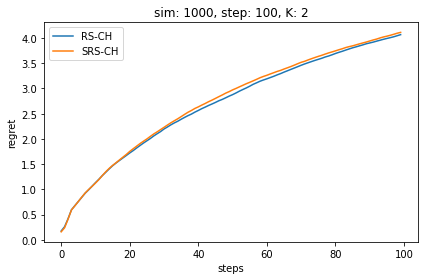

In [ ]:
def main():
    trial = 1000
    step = 100
    K = 2
    sim = Simulator(trial, step, K)
    sim.run()

main()